# Nelson Siegel Svensson (NSS) Interest Rate Model

A more advanced model to simulate interest rates. 

In [3]:
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import numpy as np
import sys, os
# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
print(f"Project root: {project_root}")
from src.data.zerocurve import Zerocurve


Project root: f:\OneDrive\Documents\GitHub\rl-alm


f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (None)/charset_normalizer (3.3.0) doesn't match a supported version!
  warnings.warn(


In [4]:
zerocurve = Zerocurve()
zerocurve.load_data()
df_z = zerocurve.df
start_date = df_z.index.min()
end_date = df_z.index.max()
yield_data = df_z.pivot(columns = 'tenor', values = 'rate')

2023-10-07 11:58:34.411 | INFO     | src.data.dataset:load_data:65 - loading zerocurve data from file.


C:\Users\M\AppData\Local\Temp\ipykernel_19688\38368981.py:3: RuntimeWarning: invalid value encountered in divide
  return beta0 + beta1 * (1 - np.exp(-t/tau1))/(t/tau1) + beta2 * ((1 - np.exp(-t/tau1))/(t/tau1) - np.exp(-t/tau1)) + beta3 * ((1 - np.exp(-t/tau2))/(t/tau2) - np.exp(-t/tau2))


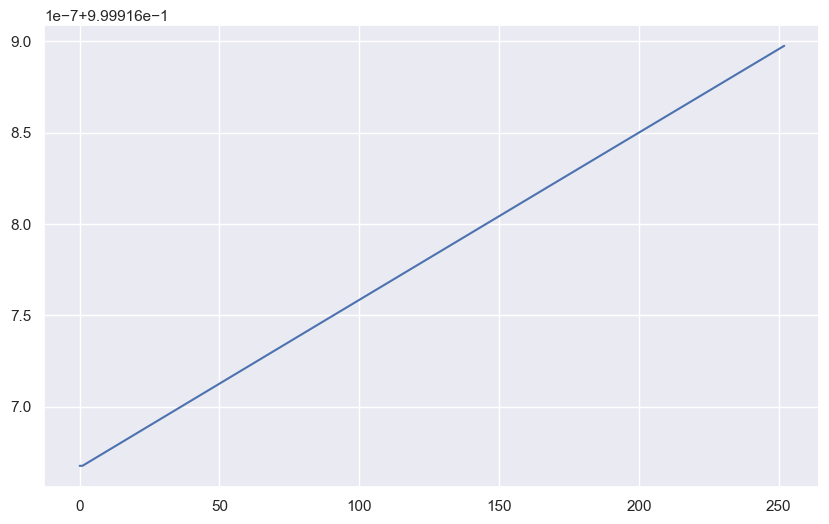

In [5]:
# Define the NSS function
def nss(t, beta0, beta1, beta2, beta3, tau1, tau2):
    return beta0 + beta1 * (1 - np.exp(-t/tau1))/(t/tau1) + beta2 * ((1 - np.exp(-t/tau1))/(t/tau1) - np.exp(-t/tau1)) + beta3 * ((1 - np.exp(-t/tau2))/(t/tau2) - np.exp(-t/tau2))

# Define the objective function to minimize the sum of squared errors between the actual and predicted yield curve
def nss_obj(x, t, y):
    return np.sum((nss(t, *x) - y)**2)

# Fit the NSS model to the historical yield data
t = np.array(yield_data.columns.values, dtype=np.float64)
y = yield_data.iloc[-1].values
x0 = [1, -0.01, -0.01, -0.01, 1, 1]
res = optimize.minimize(nss_obj, x0, args=(t, y))
beta0, beta1, beta2, beta3, tau1, tau2 = res.x

# Define a function to simulate the NSS model
def nss_simulate(t, beta0, beta1, beta2, beta3, tau1, tau2):
    return nss(t, beta0, beta1, beta2, beta3, tau1, tau2)

# Define the time horizon and time step
T = 1 # time horizon
dt = 1/252 # time step

# Simulate the NSS model
yield_curve = [nss_simulate(t[-1] + dt, beta0, beta1, beta2, beta3, tau1, tau2)]
for i in range(int(T/dt)):
    t_i = t[-1] + (i+1)*dt
    yield_i = nss_simulate(t_i, beta0, beta1, beta2, beta3, tau1, tau2)
    yield_curve.append(yield_i)

# Plot the simulated yield curve
plt.plot(yield_curve)
plt.show()